In [ ]:
from typing import TypedDict, Annotated, List, Literal, Sequence, Optional, Dict
from typing_extensions import TypedDict
from pydantic import BaseModel
import json
from IPython.display import display, Markdown, HTML

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, MessagesPlaceholder, PromptTemplate, BasePromptTemplate
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from langsmith import traceable

import matplotlib.pyplot as plt
import base64
from io import BytesIO
import numpy as np
from langchain.agents import AgentExecutor
from langchain.agents import create_tool_calling_agent
from langchain.tools import Tool
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_google_genai import ChatGoogleGenerativeAI

from dotenv import load_dotenv
import os

# Marketing Chatbot

In [2]:
class ResearchState(TypedDict):
    message: Annotated[List[BaseMessage], add_messages]

    product_description: Optional[str]
    product_type: Optional[str]
    target_market_region: Optional[str]
    target_customer_profile: Optional[str]
    problem_to_solve: Optional[str]
    business_goal: Optional[str]
    budget: Optional[str]
    timeline: Optional[str]
    your_unique_point: Optional[str]
    competitors: Optional[str]
    
    strategy_content: Optional[str]
    market_analysis: Optional[str]
    gantt_chart: Optional[str]
    gantt_tasks: Optional[List[dict]]

    information_needed: List[str]
    informationisEnough: Optional[bool]
    errors: Annotated[List[str], add_messages]
    final_report: Optional[str]
    current_field: Optional[str]
    conversation_context: Optional[str]

# Helper Functions

In [3]:
# Helper Functions
# May use LLM to generate questions based on the information needed
def get_field_description(field: str) -> str:
    """Get field descriptions for context"""
    descriptions = {
        "product_description": "Mô tả chi tiết về sản phẩm hoặc dịch vụ",
        "product_type": "Loại hình sản phẩm (ứng dụng, dịch vụ, sản phẩm vật lý, v.v.)",
        "target_market_region": "Khu vực thị trường mục tiêu (địa lý)",
        "target_customer_profile": "Hồ sơ khách hàng lý tưởng (đặc điểm)",
        "problem_to_solve": "Vấn đề cụ thể mà sản phẩm giải quyết cho khách hàng",
        "business_goal": "Mục tiêu kinh doanh và marketing cụ thể",
        "budget": "Ngân sách dự kiến cho dự án",
        "timeline": "Thời gian thực hiện dự án",
        "your_unique_point": "Điểm khác biệt và lợi thế cạnh tranh",
        "competitors": "Đối thủ cạnh tranh chính trong thị trường"
    }
    return descriptions.get(field, field)

def get_collected_info_context(state: ResearchState) -> str:
    """Get context of already collected information"""
    fields = ["product_description", "product_type", "target_market_region",
                        "target_customer_profile", "problem_to_solve", "business_goal", 
                        "budget", "timeline", "your_unique_point", "competitors"]

    context_lines = []  # save description

    for field in fields:
        value = state.get(field)  # Get field value from state

        if value:
            description = get_field_description(field)
            context_lines.append(f"- {description}: {value}")

    # Join all context lines into a single string
    if context_lines:
        return "\n".join(context_lines)
    else:
        return "Chưa có thông tin nào được thu thập."

def generate_report(state: ResearchState) -> str:
    """Generate final comprehensive report"""
    base64_image = state.get("gantt_chart")

    report = f"""
=== BÁO CÁO PHÂN TÍCH KINH DOANH ===

I. THÔNG TIN SẢN PHẨM:
- Mô tả: {state.get('product_description')}
- Loại sản phẩm: {state.get('product_type')}
- Thị trường: {state.get('target_market_region')}
- Khách hàng: {state.get('target_customer_profile')}
- Vấn đề giải quyết: {state.get('problem_to_solve')}

II. CHIẾN LƯỢC KINH DOANH:\n
{state.get('strategy_content')}

III. PHÂN TÍCH THỊ TRƯỜNG:\n
{state.get('market_analysis')}

IV. THỜI GIAN THỰC HIỆN:\n
{state.get('gantt_chart')}

"""
    return display(Markdown(report))

load_dotenv()
api_key = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = api_key

def initialize_llm():
    """Initialize and return the LLM client"""
    return ChatGoogleGenerativeAI(
            model="gemini-2.0-flash",
            temperature=0,
            max_tokens=None,
            timeout=None,
            max_retries=2,
)

llm = initialize_llm()

# Nodes

In [14]:
# Node Functions to get information
def generate_question_node(state: ResearchState) -> ResearchState:
    """Generate contextual question for the current field"""
    if not state.get("information_needed"):
        state["informationisEnough"] = True
        return state
    
    current_field = state["information_needed"][0]
    state["current_field"] = current_field
    
    # Get context of collected information
    collected_context = get_collected_info_context(state) # All the fields already collected
    field_description = get_field_description(current_field)
    

    prompt = ChatPromptTemplate.from_template("""
    Bạn là một chuyên gia tư vấn kinh doanh. Nhiệm vụ của bạn là tạo câu hỏi tự nhiên để thu thập thông tin về: {field_description}
    Chỉ tạo DUY NHẤT 1 câu hỏi để thu thập thông tin.
                                            
    THÔNG TIN ĐÃ THU THẬP:
    {collected_info}

    YÊU CẦU:
    1. Tạo câu hỏi tự nhiên, không cứng nhắc
    2. Sử dụng thông tin đã có để làm câu hỏi có ngữ cảnh
    3. Tránh lặp lại thông tin đã biết nằm trong collected_info

    CHỈ trả về câu hỏi, không có text thêm.
    """)
    
    messages = prompt.format_messages(
        field_description=field_description,
        collected_info=collected_context
    )
    
    result = llm.invoke(messages)
    question = result.content.strip()
    
    # Add question to conversation
    ai_message = AIMessage(content=question)
    state["message"].append(ai_message)
    
    print(f"\n{question}")
    return state

def validate_response_node(state: ResearchState) -> ResearchState:
    """Validate if user response is relevant and extract information"""
    if not state.get("information_needed"):
        state["informationisEnough"] = True
        return state
    
    # Check if we have a message and current field
    message = state.get("message")
    current_field = state.get("current_field")

    if message is None or current_field is None:
        return state
    
    # Check last user message
    last_message = state["message"][-1]
    if not isinstance(last_message, HumanMessage):
        return state
    
    # Get user response and field description
    user_response = last_message.content
    current_field = state["current_field"]
    field_description = get_field_description(current_field)
    
    validation_prompt = ChatPromptTemplate.from_template("""
    Phân tích xem câu trả lời của người dùng có liên quan và đủ thông tin cho câu hỏi không.

    THÔNG TIN CẦN THU THẬP: {field_description}
    
    CÂU TRẢ LỜI CỦA NGƯỜI DÙNG: {user_response}

    Trả về JSON format chính xác:
    {{
        "is_relevant": true/false,
        "extracted_info": "thông tin đã trích xuất" hoặc ""
    }}

    TIÊU CHÍ ĐÁNH GIÁ:
    - is_relevant: true nếu câu trả lời có thông tin liên quan đến field cần thu thập
    - extracted_info: rút ra những thông tin hữu ích từ câu trả lời của người dùng và sửa lại câu từ cho phù hợp và hay hơn
    CHỈ trả về JSON, không có text khác.
    """)
    
    messages = validation_prompt.format_messages(
        field_description=field_description,
        user_response=user_response
    )
    
    try:
        result = llm.invoke(messages)
        response_json = result.content.strip()
        
        # Clean JSON response
        if response_json.startswith('```'):
            response_json = response_json.split('```')[1]
            if response_json.startswith('json'):
                response_json = response_json[4:]
        
        validation_result = json.loads(response_json)
        
        is_relevant = validation_result.get("is_relevant", False)
        extracted_info = validation_result.get("extracted_info", "").strip()
        # is_sufficient = validation_result.get("is_sufficient", False)
        # clarification = validation_result.get("clarification_question", "")
        
        print(is_relevant)
        # ======= CASE 1: Thông tin liên quan và đầy đủ =======
        if is_relevant and extracted_info:
            state[current_field] = extracted_info
            if current_field in state["information_needed"]:
                state["information_needed"].remove(current_field)
                
            print(f"Đã lưu {field_description}: {extracted_info}")

            # Kiểm tra xem đã đủ thông tin chưa
            if not state["information_needed"]:
                state["informationisEnough"] = True
                done_msg = "Tuyệt vời! Tôi đã có đủ thông tin. Bây giờ tôi sẽ phân tích và tạo báo cáo cho bạn..."
                state["message"].append(AIMessage(content=done_msg))
                print(f"🎉 {done_msg}")

        # ======= CASE 2: Có liên quan nhưng chưa đủ thông tin =======
        # elif is_relevant and not is_sufficient:
        #     state[current_field] = extracted_info
        #     followup = clarification
        #     state["message"].append(AIMessage(content=followup))
        #     print(f"🔍 {followup}")

        # ======= CASE 3: Không liên quan =======
        else:
            response_msg = f"Tôi hiểu, nhưng tôi cần thông tin về {field_description.lower()}."
            # response_msg += " " + (clarification or f"Bạn có thể chia sẻ thông tin về {field_description.lower()} không?")
            state["message"].append(AIMessage(content=response_msg))
            print(f"❓ {response_msg}")

    # ======= CASE 4: Lỗi parse JSON từ LLM =======
    except json.JSONDecodeError as e:
        print(f"❌ Lỗi phân tích JSON: {e}")
        print(f"Raw response: {response_json}")

        # Nếu user trả lời có vẻ ổn thì vẫn lưu tạm
        if len(user_response.strip()) > 10:
            state[current_field] = user_response.strip()
            state["information_needed"] = [
                f for f in state["information_needed"] if f != current_field
            ]
            print(f"🔄 Fallback: Đã lưu {field_description}: {user_response.strip()}")
        else:
            retry_msg = f"Bạn có thể chia sẻ thêm thông tin về {field_description.lower()} không?"
            state["message"].append(AIMessage(content=retry_msg))
            print(f"🔄 {retry_msg}")

    return state

def final_report_node(state: ResearchState) -> ResearchState:
    """Generate and display final report"""
    report = generate_report(state)
    state["final_report"] = report
    print(report)
    return state

# Analyze Nodes
def strategy_analysis_node(state: ResearchState) -> ResearchState:
    """Create business strategy and extract tasks for Gantt chart"""
    print("Phân tích chiến lược kinh doanh")
    
    # Get strategy content
    strategy_prompt = ChatPromptTemplate.from_template("""
    Dựa trên thông tin sản phẩm sau, hãy tạo nội dung chiến lược kinh doanh chi tiết:

    Sản phẩm: {product_description}
    Loại: {product_type}  
    Thị trường: {target_market_region}
    Khách hàng: {target_customer_profile}
    Vấn đề giải quyết: {problem_to_solve}
    Mục tiêu: {business_goal}
    Ngân sách: {budget}
    Thời gian: {timeline}
    Điểm khác biệt: {unique_point}
    Đối thủ: {competitors}

    Hãy tạo chiến lược logic bao gồm:
    1. Định vị sản phẩm
    2. Chiến lược tiếp thị
    3. Kế hoạch phát triển
    4. Chiến lược cạnh tranh
    5. Roadmap thực hiện chi tiết

    Trả lời bằng tiếng Việt, chi tiết và chuyên nghiệp. Vào vấn đề chính ngay từ đầu. Không cần mở đầu dài dòng
    """)
    # Viết dưới dạng HTML với các tiêu đề rõ ràng.

    strategy_messages = strategy_prompt.format_messages(
        product_description=state.get('product_description'),
        product_type=state.get('product_type'),
        target_market_region=state.get('target_market_region'),
        target_customer_profile=state.get('target_customer_profile'),
        problem_to_solve=state.get('problem_to_solve'),
        business_goal=state.get('business_goal'),
        budget=state.get('budget'),
        timeline=state.get('timeline'),
        unique_point=state.get('your_unique_point'),
        competitors=state.get('competitors')
    )
    
    strategy_result = llm.invoke(strategy_messages)
    state["strategy_content"] = strategy_result.content
    
    print("Hoàn thành phân tích chiến lược")
    return state

def gantt_task_extract_node(state: ResearchState) -> ResearchState:
    """Extract tasks for Gantt chart from strategy analysis"""
    
    # Extract tasks for Gantt chart
    tasks_prompt = ChatPromptTemplate.from_template("""
    Dựa trên thông tin dự án và thời gian thực hiện, hãy tạo danh sách tasks cho biểu đồ Gantt:

    Thời gian thực hiện: {timeline}
    Sản phẩm: {product_description}
    Loại sản phẩm: {product_type}
    Ngân sách: {budget}
    Mục tiêu: {business_goal}

    Trả về CHÍNH XÁC format JSON sau, không thêm text gì khác:
    [
        {{"name": "Tên nhiệm vụ 1", "start": 0, "duration": 2}},
        {{"name": "Tên nhiệm vụ 2", "start": 1, "duration": 3}},
        {{"name": "Tên nhiệm vụ 3", "start": 3, "duration": 2}}
    ]

    Trong đó:
    - name: Tên nhiệm vụ bằng tiếng Việt
    - start: Tháng bắt đầu (từ 0)
    - duration: Số tháng thực hiện

    Tạo 6-8 nhiệm vụ hợp lý cho dự án này. Các nhiệm vụ có thể chồng lấn về thời gian. 
    CHỈ trả về JSON, không có text thêm.
    """)
    
    tasks_messages = tasks_prompt.format_messages(
        timeline=state.get('timeline'),
        product_description=state.get('product_description'),
        product_type=state.get('product_type'),
        budget=state.get('budget'),
        business_goal=state.get('business_goal')
    )
    
    tasks_result = llm.invoke(tasks_messages)
    
    try:
        
        tasks_json = tasks_result.content.strip()
        # Remove any potential markdown formatting
        if tasks_json.startswith('```'):
            tasks_json = tasks_json.split('```')[1]
            if tasks_json.startswith('json'):
                tasks_json = tasks_json[4:]
        
        tasks = json.loads(tasks_json)
        state["gantt_tasks"] = tasks
        print(f"Đã tạo {len(tasks)} nhiệm vụ cho Gantt chart")
        
    except json.JSONDecodeError as e:
        print(f"Lỗi parse JSON: {e}")

    print("Hoàn thành phân tích task Gantt")
    return state

def market_analysis_node(state: ResearchState) -> ResearchState:
    """Analyze market situation"""
    print("Phân tích tình hình thị trường")
    
    prompt = ChatPromptTemplate.from_template("""
    Dựa trên thông tin sau, hãy thực hiện phân tích thị trường chi tiết:

    Sản phẩm: {product_description}
    Thị trường: {target_market_region}
    Khách hàng: {target_customer_profile}
    Đối thủ: {competitors}
    Ngân sách: {budget}

    Phân tích bao gồm:
    1. Quy mô và tiềm năng thị trường
    2. Xu hướng thị trường hiện tại
    3. Phân khúc khách hàng
    4. Phân tích đối thủ cạnh tranh
    5. Cơ hội và thách thức
    6. Đề xuất các từ khóa và chủ đề cần nghiên cứu thêm trên web

    Trả lời dựa trên dữ liệu thực tế và xu hướng hiện tại. Vào vấn đề chính ngay từ đầu. Không cần mở đầu dài dòng. 
    """)
        # Viết dưới dạng HTML với các tiêu đề rõ ràng.

    messages = prompt.format_messages(
        product_description=state.get('product_description', ''),
        target_market_region=state.get('target_market_region', ''),
        target_customer_profile=state.get('target_customer_profile', ''),
        competitors=state.get('competitors', ''),
        budget=state.get('budget', '')
    )
    
    result = llm.invoke(messages)
    state["market_analysis"] = result.content
    return state

def create_gantt_chart_node(state: ResearchState) -> ResearchState:
    """Create Gantt chart using tasks from strategy analysis"""
    print("Tạo biểu đồ Gantt")
    
    try:
        # Get tasks from strategy analysis
        tasks = state.get("gantt_tasks", [])
        
        if not tasks:
            print("Không có tasks từ strategy analysis")
            state["gantt_chart"] = "Lỗi: Không có dữ liệu tasks"
            return state
        
        fig, ax = plt.subplots(figsize=(14, len(tasks) + 2))
        
        # Colors for different tasks
        colors = plt.cm.Set3(np.linspace(0, 1, len(tasks)))
        
        # Plot each task
        for i, (task, color) in enumerate(zip(tasks, colors)):
            name = task.get('name', f'Task {i+1}')
            start = task.get('start', 0)
            duration = task.get('duration', 1)
            
            # Create bar for task
            ax.barh(i, duration, left=start, color=color, alpha=0.7, height=0.6)
            
            # Add task name inside or beside the bar
            text_x = start + duration/2 if duration > 2 else start + duration + 0.1
            ax.text(text_x, i, name, ha='center' if duration > 2 else 'left', 
                   va='center', fontweight='bold', fontsize=10)
            
            # Add duration info
            ax.text(start + duration + 0.5, i, f'{duration}th', 
                   ha='left', va='center', fontsize=8, style='italic')
        
        # Customize chart
        ax.set_xlabel('Tháng', fontsize=12, fontweight='bold')
        ax.set_ylabel('Nhiệm vụ', fontsize=12, fontweight='bold')
        ax.set_title('Biểu đồ Gantt - Kế hoạch thực hiện dự án', 
                    fontsize=14, fontweight='bold', pad=20)
        
        # Set y-axis
        ax.set_yticks(range(len(tasks)))
        ax.set_yticklabels([f'Task {i+1}' for i in range(len(tasks))])
        ax.invert_yaxis()  # Top to bottom
        
        # Set x-axis
        max_time = max([task.get('start', 0) + task.get('duration', 1) for task in tasks])
        ax.set_xlim(0, max_time + 2)
        ax.set_xticks(range(0, max_time + 3))
        
        # Add grid
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        ax.grid(axis='y', alpha=0.1)
        
        # Add timeline info
        timeline_info = state.get('timeline', 'Không xác định')
        ax.text(0.02, 0.98, f'Tổng thời gian dự án: {timeline_info}', 
               transform=ax.transAxes, fontsize=10, 
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5),
               verticalalignment='top')
        
        # plt.tight_layout()
        # chart_path = 'gantt_chart.png'
        # plt.savefig(chart_path, dpi=300, bbox_inches='tight', 
        #            facecolor='white', edgecolor='none')
        # plt.close()
        
        # state["gantt_chart"] = chart_path

        plt.tight_layout()
        buf = BytesIO()
        plt.savefig(buf, format='png', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
        plt.close()
        buf.seek(0)

        img_base64 = base64.b64encode(buf.read()).decode('utf-8')
        state["gantt_chart_base64"] = img_base64
        
        print(f"Đã tạo biểu đồ Gantt")
        
    except Exception as e:
        state["gantt_chart"] = f"Lỗi tạo biểu đồ Gantt: {str(e)}"
        print(f"Lỗi tạo biểu đồ Gantt: {e}")
    
    return state
    

def should_continue_conversation(state: ResearchState) -> str:
    """Decide whether to continue asking questions or proceed to analysis"""
    is_enough = state.get("informationisEnough")

    if is_enough:
        return "analyze"
    else:
        return "generate"


# Graph

In [15]:
graph_builder = StateGraph(ResearchState)

# Add nodes
graph_builder.add_node("generate_question", generate_question_node)
graph_builder.add_node("validate_response", validate_response_node)

# Analysis nodes (only 3 as requested)
graph_builder.add_node("analyze", strategy_analysis_node)
graph_builder.add_node("gantt_task_extract", gantt_task_extract_node)
graph_builder.add_node("market", market_analysis_node)
graph_builder.add_node("gantt_chart", create_gantt_chart_node)
graph_builder.add_node("final_report", final_report_node)

# Add edges
graph_builder.set_entry_point("generate_question")

graph_builder.add_conditional_edges("validate_response", should_continue_conversation, {
    "generate": "generate_question",
    "analyze": "analyze"
})

# Analysis chain (simplified to 3 nodes)
graph_builder.add_edge("generate_question", "validate_response")
graph_builder.add_edge("analyze", "gantt_task_extract")
graph_builder.add_edge("gantt_task_extract", "market")
graph_builder.add_edge("market", "gantt_chart")
graph_builder.add_edge("gantt_chart", "final_report")

graph_builder.add_edge("final_report", END)

# Compile graph with interrupt
graph = graph_builder.compile(
    checkpointer=MemorySaver(),
    interrupt_after=["generate_question"]
)

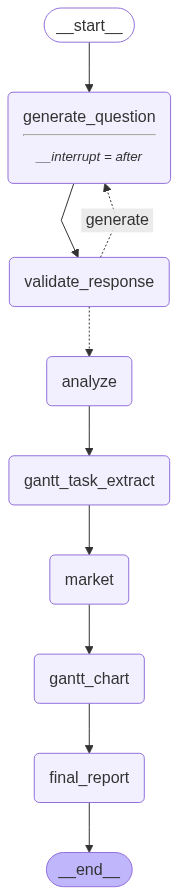

In [13]:
graph

# Conversation

In [16]:
config = {"configurable": {"thread_id": "3"}}

# Initial state
initial_state = {
    "message": [],
    "information_needed": [
        "product_description", "product_type", "target_market_region",
        "target_customer_profile", "problem_to_solve", "business_goal", 
        "budget", "timeline", "your_unique_point", "competitors"
    ],
    "informationisEnough": False,
    "errors": [],
    "current_field": None,
    "conversation_context": "",
    "final_report": None,
    # Analysis fields
    "strategy_content": None,
    "market_analysis": None,
    "gantt_tasks": None,
    "gantt_chart": None
}

# Start conversation
graph.invoke(initial_state, config=config)

# Continue until done
while True:
    snapshot = graph.get_state(config)
    if snapshot.values.get("informationisEnough", False):
        print("\nChuyển sang phân tích...")
        break
        
    try:
        answer = input("\nUser: ").strip()
        if answer.lower() in ['quit', 'exit']:
            break
            
        if answer:
            # Add user message to state
            current_state = snapshot.values
            current_state["message"].append(HumanMessage(content=answer))
            
            # Continue conversation
            graph.update_state(config, current_state)
            graph.invoke(None, config=config)
            
    except KeyboardInterrupt:
        break
    except Exception as e:
        print(f"Lỗi: {e}")


Để hiểu rõ hơn về những gì bạn đang cung cấp, bạn có thể mô tả chi tiết hơn về sản phẩm hoặc dịch vụ của mình được không?
True
Đã lưu Mô tả chi tiết về sản phẩm hoặc dịch vụ: Phần mềm hỗ trợ quản lý nhà hàng.

Vậy, phần mềm quản lý nhà hàng này tập trung vào những khía cạnh cụ thể nào của hoạt động kinh doanh nhà hàng ạ?
False
❓ Tôi hiểu, nhưng tôi cần thông tin về loại hình sản phẩm (ứng dụng, dịch vụ, sản phẩm vật lý, v.v.).

Vậy, phần mềm quản lý nhà hàng này tập trung vào những khía cạnh cụ thể nào của hoạt động kinh doanh nhà hàng ạ?
True
Đã lưu Loại hình sản phẩm (ứng dụng, dịch vụ, sản phẩm vật lý, v.v.): Phần mềm

"Để phần mềm quản lý nhà hàng của bạn phát huy hiệu quả tối đa, anh/chị đang nhắm đến khu vực địa lý cụ thể nào để tập trung phát triển thị trường?"
True
Đã lưu Khu vực thị trường mục tiêu (địa lý): Khu vực thị trường mục tiêu: Ngũ Hành Sơn, Đà Nẵng

"Để phần mềm quản lý nhà hàng của chúng tôi thực sự phù hợp và mang lại hiệu quả tối ưu cho các nhà hàng tại khu vực N

In [8]:
graph.get_state(config)

StateSnapshot(values={'message': [AIMessage(content='Để hiểu rõ hơn về những gì bạn đang cung cấp, bạn có thể mô tả chi tiết hơn về sản phẩm hoặc dịch vụ của mình được không?', additional_kwargs={}, response_metadata={}, id='9edc14a9-d12c-4ce9-aa65-b44f434a3d79'), HumanMessage(content='Sản phẩm của tôi hỗ trợ các quán caffe quản lý lượng khách hàng và nhân viên tốt hơn', additional_kwargs={}, response_metadata={}, id='9d2cf80b-6569-4dd9-a5e7-7104268f5224'), AIMessage(content='Để giúp quán cafe quản lý khách hàng và nhân viên hiệu quả hơn, sản phẩm này sẽ tập trung vào phần mềm, dịch vụ hay một giải pháp vật lý nào khác ạ?', additional_kwargs={}, response_metadata={}, id='a1f9ddd5-e10a-4a6a-b266-8fa102eec0fb'), HumanMessage(content='đây là một phần mềm được sử dụng bởi người quản lý', additional_kwargs={}, response_metadata={}, id='2c3cacff-9fce-4ea4-ac15-981c750bfc1a'), AIMessage(content='"Để phần mềm quản lý quán cafe của mình phát huy hiệu quả tốt nhất, anh/chị đang nhắm đến các khu 

# Chatbot Testing

In [9]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [53]:
api_key = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = api_key

def initialize_llm():
    """Initialize and return the LLM client"""
    return ChatGoogleGenerativeAI(
            model="gemini-2.0-flash",
            temperature=0,
            max_tokens=None,
            timeout=None,
            max_retries=2,
)

llm = initialize_llm()

In [54]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

search = GoogleSerperAPIWrapper()
search_tool = Tool(
    name="google_search",
    func=search.run,
    description="Use this tool to search Google using Serper API.",
    return_direct=True
)

tools = [search_tool]
llm_with_tools = llm.bind_tools(tools)

In [ ]:
memory = MemorySaver()
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[search_tool])
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")

graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_after=["tools"],
)

config = {"configurable": {"thread_id": "1"}}

while True:
    user_input = input("User:")
    if user_input.lower() in ["q", "quit", "exit"]:
        print("GoodBye !!")
        break
    for event in graph.stream(
        {"messages": ("user", user_input)}, config, stream_mode="values"
    ):
        event["messages"][-1].pretty_print()

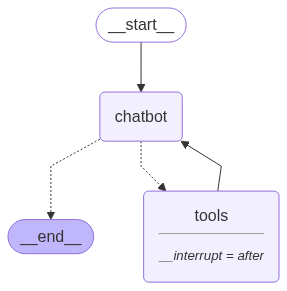

In [56]:
graph